In [7]:
from io import BytesIO


import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from cairosvg import svg2png

In [8]:
def load_img(path: str):
    '''Load image as numpy array in grayscale.'''

    # open image
    img = cv2.imread(path)
    # convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return img


def load_diamonds(style):
    
    # change order of files to change color distribution
    diamonds_style = {
        'gray': [
            'diamonds/gray/brick 0.png', # black
            'diamonds/gray/brick 1.png',
            'diamonds/gray/brick 2.png',
            'diamonds/gray/brick 3.png',
            'diamonds/gray/brick 4.png' # white
        ],
        'popart': [
            'diamonds/popart/brick X.svg',
            'diamonds/popart/brick A.svg',
            'diamonds/popart/brick T.svg',
            'diamonds/popart/brick E.svg',
            'diamonds/popart/brick M.svg',
            'diamonds/popart/brick L.svg',
            'diamonds/popart/brick O.svg'
        ],
        'sapfir': [
            'diamonds/sapfir/brick Y.svg',
            'diamonds/sapfir/brick U.svg',
            'diamonds/sapfir/brick G.svg',
            'diamonds/sapfir/brick R.svg',
            'diamonds/sapfir/brick I.svg',
            'diamonds/sapfir/brick H.svg',
            'diamonds/sapfir/brick O.svg'
        ],
        'sepia': [
            'diamonds/sepia/brick X.svg',
            'diamonds/sepia/brick S.svg',
            'diamonds/sepia/brick F.svg',
            'diamonds/sepia/brick W.svg',
            'diamonds/sepia/brick K.svg',
            'diamonds/sepia/brick P.svg',
            'diamonds/sepia/brick O.svg'
        ]
    }

    if style == 'gray':
        diamonds = [cv2.imread(path) for path in diamonds_style[style]]
        diamonds = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY), diamonds))
    else:
        diamonds = []
        for path in diamonds_style[style]:
            with open(path) as f:
                img = svg2png(file_obj=f)
            pil_img = Image.open(BytesIO(img)).convert('RGB')
            cv_img = np.array(pil_img)
            diamonds.append(cv_img)
    
    return diamonds


def img_to_diamonds(
        img, dim, thresholds, style='gray', 
        brightness=1.25, 
        clipLimit=2, 
        clahe_grid=(8,8)
):
    '''Pixelize image and fill it with diamonds'''

    img = img.copy()

    diamonds = load_diamonds(style)
    assert len(thresholds) == len(diamonds), 'thresholds and diamonds arrays must be the same length'

    img = cv2.convertScaleAbs(img, alpha=brightness)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=clahe_grid)
    img = clahe.apply(img)
    img = cv2.GaussianBlur(img, (9, 9), 0)

    # resize img
    img_pix = cv2.resize(img, dim)
    
    # make lut for Image.point
    lut = []
    counter = 256
    for i in thresholds[::-1]:
        lut.extend([i] * (counter - i))
        counter = i
    lut = lut[::-1]

    img_pix = Image.fromarray(img_pix).point(lut)
    img_pix = np.array(img_pix)

    diamonds_map = {}
    for t, d in zip(thresholds, diamonds):
        diamonds_map.update({t: d})

    # fill img_diamonds with diamonds according to img_pix and diamonds_map
    if style == 'gray':
        diam_size = diamonds[0].shape[0]
        img_diamonds = np.zeros((img_pix.shape[0]*diam_size, img_pix.shape[1]*diam_size), dtype=np.uint8)

        # turn pixels to diamonds
        for i in range(img_pix.shape[0]):
            for j in range(img_pix.shape[1]):
                img_diamonds[i*diam_size:(i+1)*diam_size, j*diam_size:(j+1)*diam_size] = diamonds_map[img_pix[i][j]]
    
    else:
        diam_size = diamonds[0].shape[0]
        img_diamonds = np.zeros((img_pix.shape[0]*diam_size, img_pix.shape[1]*diam_size, 3), dtype=np.uint8)
        
        # turn pixels to diamonds
        for i in range(img_pix.shape[0]):
            for j in range(img_pix.shape[1]):
                img_diamonds[i*diam_size:(i+1)*diam_size, j*diam_size:(j+1)*diam_size, :] = diamonds_map[img_pix[i][j]]

    return img_diamonds


def show_pic(img):
    '''Display img.'''
    plt.imshow(img, cmap='gray')
    plt.axis('off')


def save_pic(img, filename):
    '''Save img with specified filename.'''
    cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
path_to_img = 'img.jpg'

img = load_img(path_to_img)

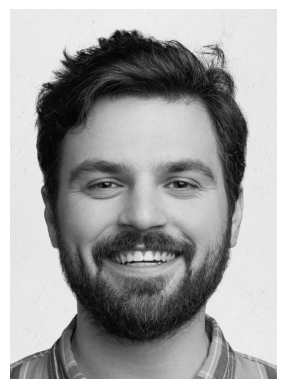

In [10]:
# cut img around face (only for a beard-man in img.jpg)
img = img[0:img.shape[0]-1000, 1400:img.shape[1]-1400]
show_pic(img)

In [11]:
# thresholds = [0, 56, 102, 143, 226]
# replace pixels with tone from 0 to 56 with black diamonds
# from 226 to 256 with white diamonds
# thresholds = [0, 56, 102, 180, 200] # use this with grayscale
thresholds = [0, 37, 74, 111, 148, 185, 256] # number of thresholds must be the same as number of diamonds

brightness = 0.9
clipLimit = 2 # contrast limit for CLAHE
clahe_grid = (8, 8) # grid for CLAHE

# available styles: gray, popart, sapfir, sepia

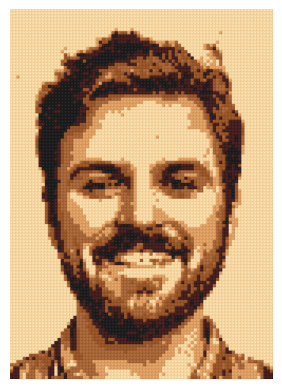

In [12]:
dim = (83, 117) # values for img resizing 

diamonded_img = img_to_diamonds(
    img,
    dim=dim,
    thresholds=thresholds,
    style='sepia',
    brightness=brightness,
    clipLimit=clipLimit,
    clahe_grid=clahe_grid
)

show_pic(diamonded_img)
# save_pic(diamonded_img, 'example_83_117.jpg')

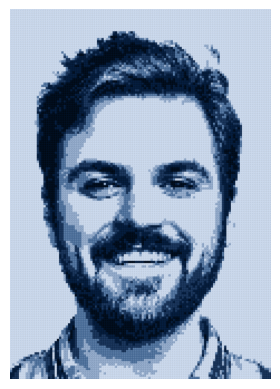

In [7]:
dim = (117, 166)

diamonded_img = img_to_diamonds(
    img,
    dim=dim,
    thresholds=thresholds,
    style='sapfir',
    brightness=brightness,
    clipLimit=clipLimit,
    clahe_grid=clahe_grid
)

show_pic(diamonded_img)
# save_pic(diamonded_img, 'example_117_166.jpg')